# Example Usage for Packaged Neural Networks

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

os.chdir('./BayesHI') # Replace this with the location of the BayesHI directory
import bayeshi

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Load one of the models

In [3]:
model = bayeshi.load_model('bayeshi')

In [4]:
model = model.to(device)

## Load the pre-trained weights for the model

In [5]:
model.load_weights()

Loading model from /home/120/em8117/BayesHI/bayeshi/weights/tigress.pth
Model loaded successfully


## Predict on some dummy spectra

In [6]:
spectra = bayeshi.generate_spectra()

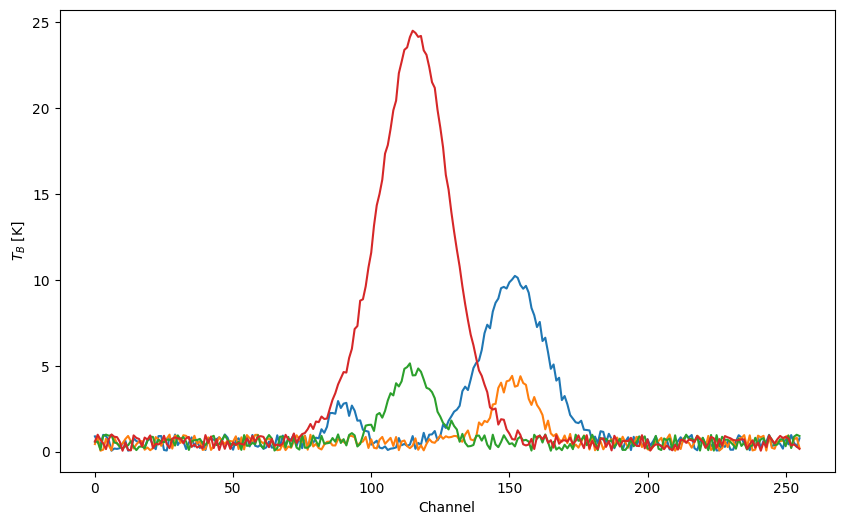

In [7]:
plt.figure(figsize=(10,6))
plt.plot(spectra[45:49].T)
plt.xlabel('Channel')
plt.ylabel(r'$T_B$ [K]')
plt.show()

### Create a dataloader from the dummy spectra

In [8]:
data_loader = DataLoader(
    TensorDataset(
        torch.Tensor(spectra).to(device)
    ), 
    batch_size=32, 
    shuffle=False
)

### Predict on the spectra

In [9]:
predictions = model.predict(data_loader, numPredictions=10).cpu().numpy()

Predicting: 100%|██████████| 10/10 [00:00<00:00, 30.32it/s]


### Take the average and standard deviation of the predictions

In [10]:
avg_predictions = np.mean(predictions, axis = 0)
std_predictions = np.std(predictions, axis = 0)

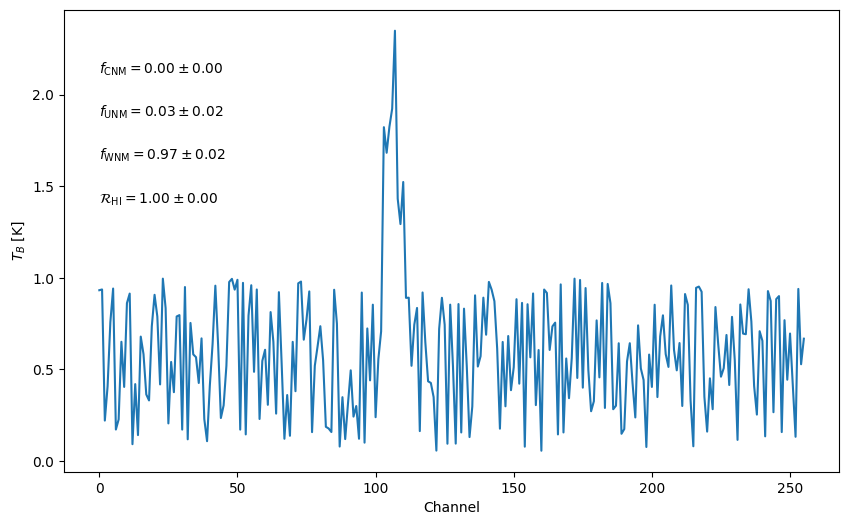

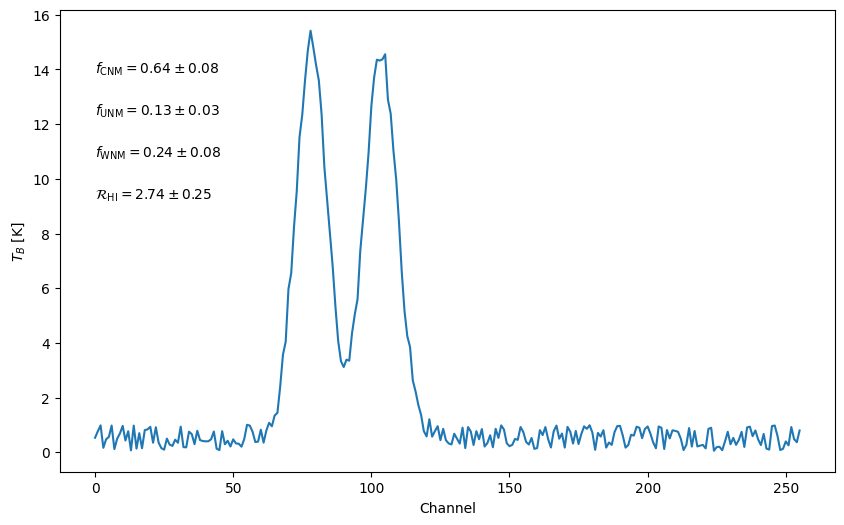

In [11]:
# Get the spectra with the highest and lowest predicted fcnm
min_cnm = np.argmin(avg_predictions[:,0])
max_cnm = np.argmax(avg_predictions[:,0])

bayeshi.plot_spectrum(spectra, predictions, min_cnm)
bayeshi.plot_spectrum(spectra, predictions, max_cnm)

## Load the other two networks and compare

In [12]:
tpc_model = bayeshi.load_model('tpcnet_all_phases').to(device)
saury_model = bayeshi.load_model('saury').to(device)

/home/120/em8117/.local/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [21]:
# model.load_weights()
tpc_model.load_state_dict(torch.load('/home/120/em8117/BayesHI/checkpoints/tpcnet_training.pth'))
saury_model.load_state_dict(torch.load('/home/120/em8117/BayesHI/bayeshi/weights/saury.pth'))

RuntimeError: Error(s) in loading state_dict for saury_model:
	Missing key(s) in state_dict: "conv_layers.2.weight_mu", "conv_layers.2.weight_log_sigma", "conv_layers.2.bias_mu", "conv_layers.2.bias_log_sigma". 
	size mismatch for decoder.weight_mu: copying a param with shape torch.Size([4, 2472]) from checkpoint, the shape in current model is torch.Size([4, 1164]).
	size mismatch for decoder.weight_log_sigma: copying a param with shape torch.Size([4, 2472]) from checkpoint, the shape in current model is torch.Size([4, 1164]).

In [13]:
tpc_predictions = tpc_model.predict(data_loader, numPredictions=1).cpu().numpy() # TPCNet model is not Bayesian, so use only one prediction
saury_predictions = saury_model.predict(data_loader, numPredictions=10).cpu().numpy()

Predicting: 100%|██████████| 10/10 [00:00<00:00, 218.20it/s]


### Take the average and standard deviation of the predictions

In [14]:
avg_saury_predictions = np.mean(saury_predictions, axis=0)
std_saury_predictions = np.std(saury_predictions, axis=0)

In [15]:
tpc_predictions.shape

(1, 100, 4)

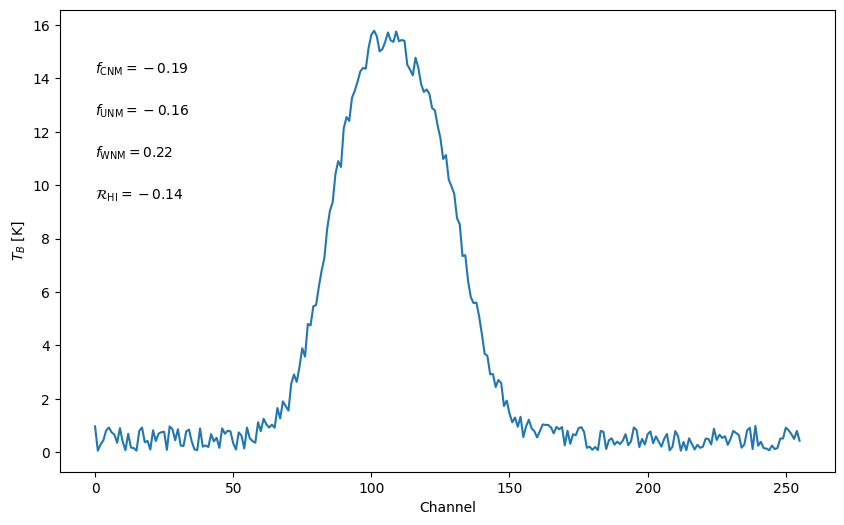

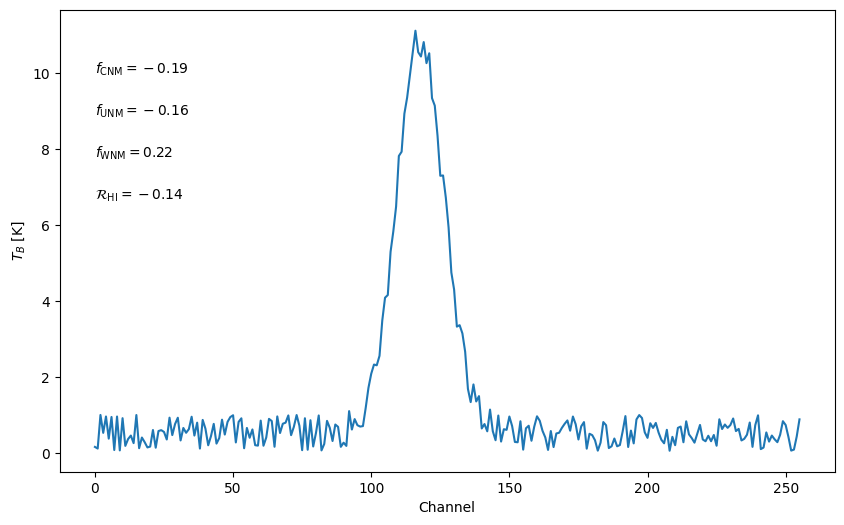

In [16]:
# Get the spectra with the highest and lowest predicted fcnm
tpc_min_cnm = np.argmin(tpc_predictions[:,0])
tpc_max_cnm = np.argmax(tpc_predictions[:,0])

bayeshi.plot_spectrum(spectra, tpc_predictions, tpc_min_cnm)
bayeshi.plot_spectrum(spectra, tpc_predictions, tpc_max_cnm)

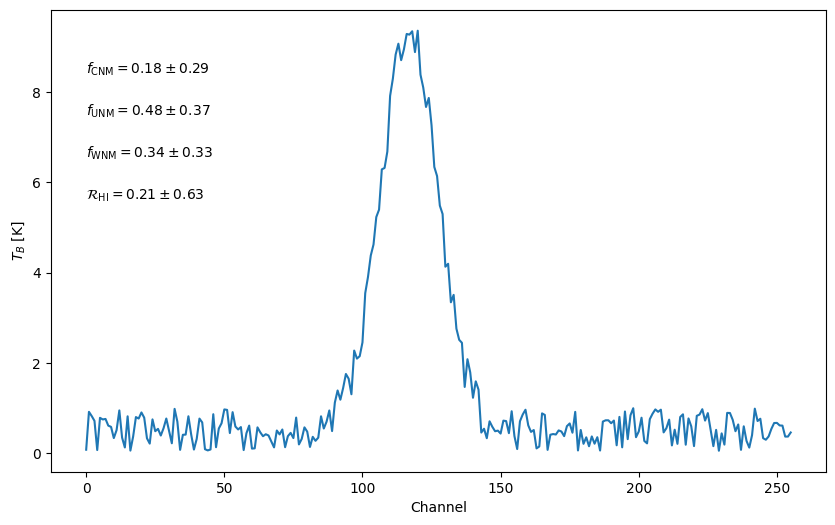

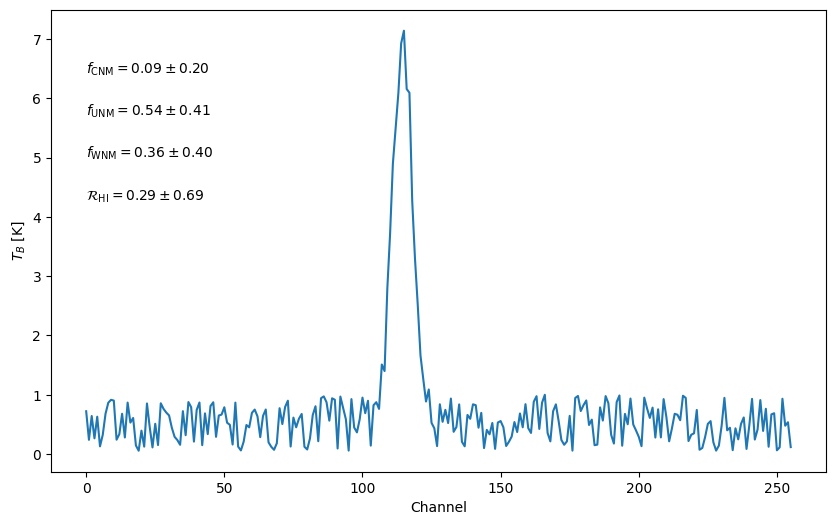

In [17]:
# Get the spectra with the highest and lowest predicted fcnm
saury_min_cnm = np.argmin(saury_predictions[:,0])
saury_max_cnm = np.argmax(saury_predictions[:,0])

bayeshi.plot_spectrum(spectra, saury_predictions, saury_min_cnm)
bayeshi.plot_spectrum(spectra, saury_predictions, saury_max_cnm)

## Train the network from scratch

In [12]:
# This reinitialises the model
model = bayeshi.load_model('bayeshi')

In [13]:
model = model.to(device)

### Generate dummy spectra and targets ($f_\text{CNM}$, $f_\text{UNM}$, $f_\text{WNM}$, $\mathcal{R}_\text{HI}$)

In [14]:
spectra = bayeshi.generate_spectra(num_spectra=10000, max_components=6)
# Fractions must sum to one
fractions = np.random.dirichlet(alpha=[1, 1, 1], size=10000)
rhi = 1 + np.random.exponential(scale=0.05, size=(10000,1))

targets = np.concatenate((fractions,rhi),axis=1)

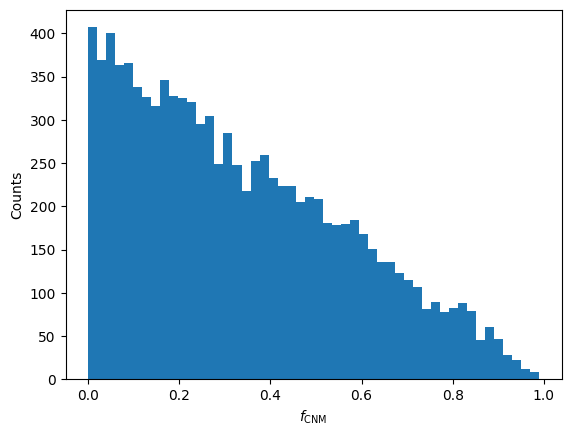

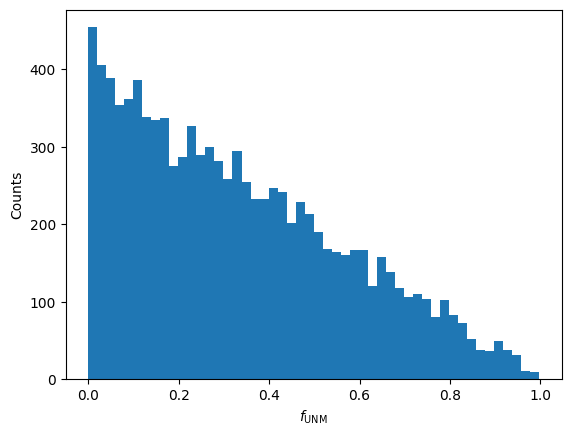

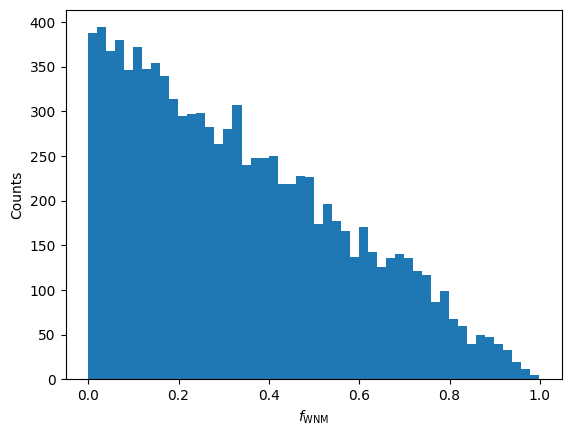

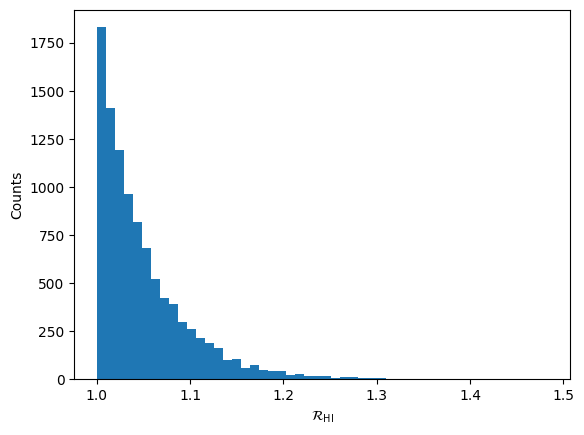

In [15]:
plt.hist(targets[:,0],bins=50)
plt.xlabel(r'$f_\text{CNM}$')
plt.ylabel('Counts')
plt.show()

plt.hist(targets[:,1],bins=50)
plt.xlabel(r'$f_\text{UNM}$')
plt.ylabel('Counts')
plt.show()

plt.hist(targets[:,2],bins=50)
plt.xlabel(r'$f_\text{WNM}$')
plt.ylabel('Counts')
plt.show()

plt.hist(targets[:,3],bins=50)
plt.xlabel(r'$\mathcal{R}_\text{HI}$')
plt.ylabel('Counts')
plt.show()

In [16]:
# Check that the fractions sum to one
targets[:,:3].sum(axis=1).all() == 1

True

### Create a dataloader from the dummy spectra and targets

In [17]:
# Split into train and validation sets with 80:20 split
X_train, X_val, y_train, y_val = train_test_split(spectra, targets, test_size=0.2, random_state=42)

train_loader = DataLoader(
    TensorDataset(
        torch.Tensor(X_train).to(device),
        torch.Tensor(y_train).to(device)
    ), 
    batch_size=32, 
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_val).to(device),
        torch.tensor(y_val).to(device)
    ),
    batch_size=32,
    shuffle=False
)

### Train the network

In [18]:
train_errors, val_errors, trained_epochs, epoch_times = model.fit(train_loader, val_loader, './checkpoints/dummy_bayeshi.pth', nEpochs=100)

Training Model
Initial learning rate: [0.0001]
Epoch [1/100], Train Loss: 0.2664, Validation Loss: 0.2511, took 4.50s
Epoch [2/100], Train Loss: 0.1657, Validation Loss: 0.1737, took 4.36s
Epoch [3/100], Train Loss: 0.1681, Validation Loss: 0.1631, took 4.35s
Epoch [4/100], Train Loss: 0.1606, Validation Loss: 0.1651, took 4.36s
Epoch [5/100], Train Loss: 0.1650, Validation Loss: 0.1692, took 4.34s
Epoch [6/100], Train Loss: 0.1678, Validation Loss: 0.1768, took 4.35s
Epoch [7/100], Train Loss: 0.1571, Validation Loss: 0.1670, took 4.36s
Epoch [8/100], Train Loss: 0.1604, Validation Loss: 0.1702, took 4.35s
Epoch [9/100], Train Loss: 0.1642, Validation Loss: 0.1573, took 4.35s
Epoch [10/100], Train Loss: 0.1632, Validation Loss: 0.1662, took 4.35s
Epoch [11/100], Train Loss: 0.1579, Validation Loss: 0.1555, took 4.34s
Epoch [12/100], Train Loss: 0.1687, Validation Loss: 0.1495, took 4.35s
Epoch [13/100], Train Loss: 0.1633, Validation Loss: 0.1589, took 4.35s
Epoch [14/100], Train Loss

### Load the trained network parameters

In [19]:
model.load_weights('./checkpoints/dummy_bayeshi.pth')

Loading model from ./checkpoints/dummy_bayeshi.pth
Model loaded successfully


### Plot training and testing losses

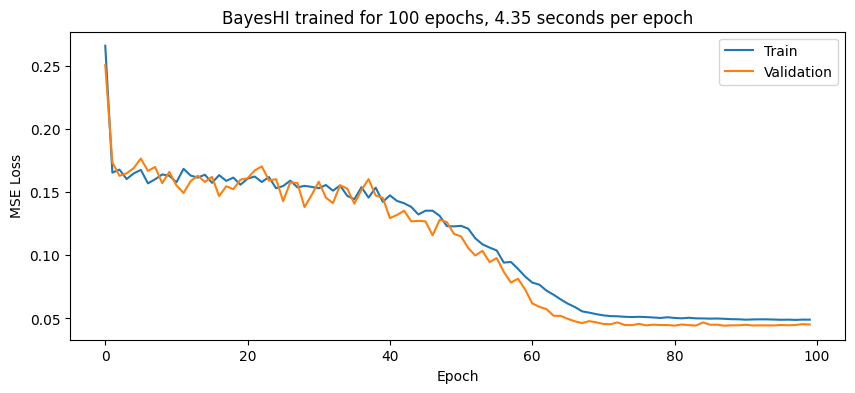

In [25]:
plt.figure(figsize=(10,4))
plt.plot(train_errors, label='Train')
plt.plot(val_errors, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title(f'BayesHI trained for {trained_epochs} epochs, {np.array(epoch_times).mean():.2f} seconds per epoch')
plt.show()

### Get test loss and predict on a test set

In [26]:
test_spectra = bayeshi.generate_spectra(num_spectra=1000, max_components=6)

test_fractions = np.random.dirichlet(alpha=[1, 1, 1], size=1000)
test_rhi = 1 + np.random.exponential(scale=0.05, size=(1000,1))
test_targets = np.concatenate((test_fractions, test_rhi),axis=1)

test_loader = DataLoader(
    TensorDataset(
        torch.Tensor(test_spectra).to(device),
        torch.Tensor(test_targets).to(device)
    ), 
    batch_size=32, 
    shuffle=False
)

In [27]:
from torch import nn
test_loss = model.evaluate(test_loader, nn.MSELoss())
print('Test loss (MSE):', test_loss)

Test loss (MSE): 0.04377363936509937


In [28]:
test_predictions = model.predict(test_loader, numPredictions=10).cpu().numpy()

Predicting: 100%|██████████| 10/10 [00:00<00:00, 26.27it/s]


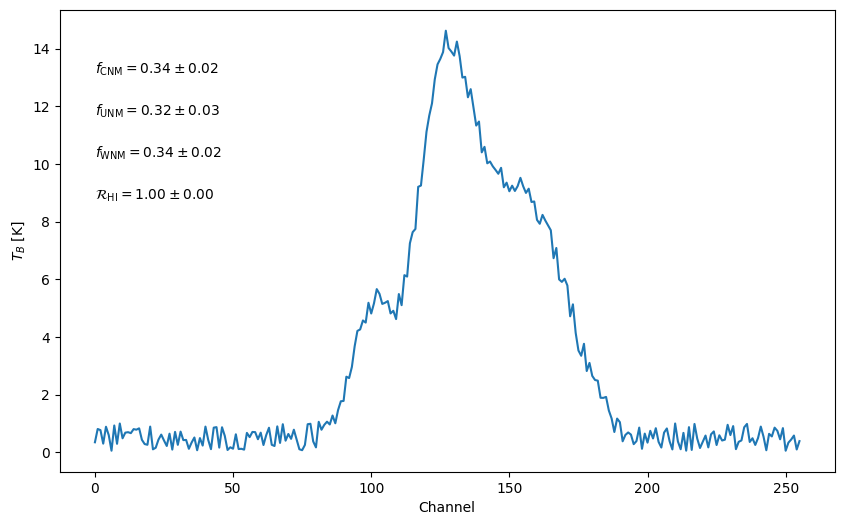

In [30]:
bayeshi.plot_spectrum(test_spectra, test_predictions, 0)

### Plot some one-to-one plots

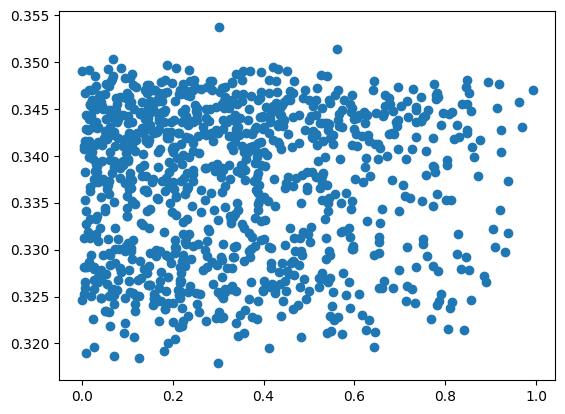

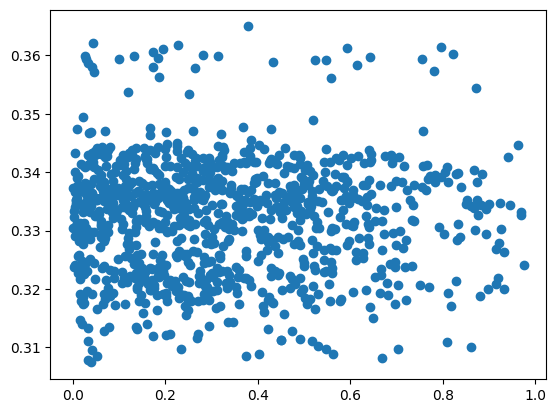

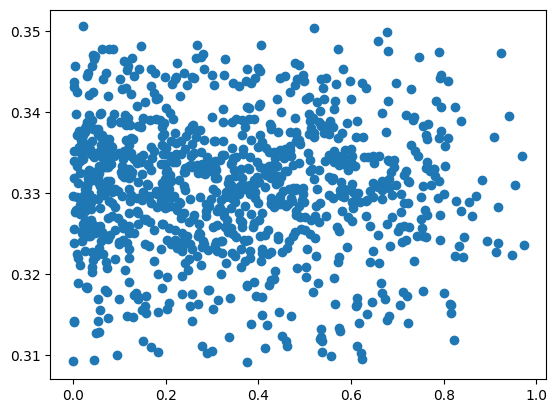

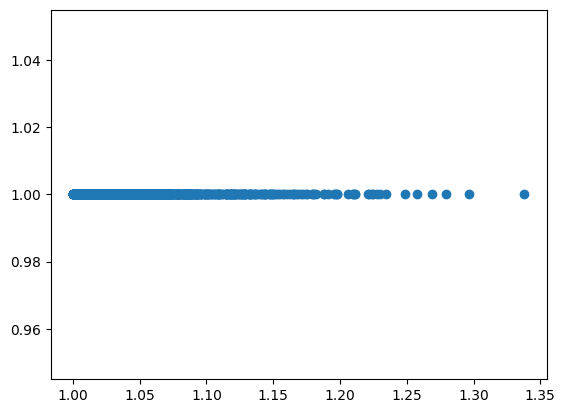

In [31]:
for i in range(4):
    plt.scatter(test_targets[:,i], np.mean(test_predictions,axis=0)[:,i])
    plt.show()